# GloVe
Using the large abstract data encoded with the balanced title tokens.

# Imports and Setup

Common imports and standardized code for importing the relevant data, models, etc., in order to minimize copy-paste/typo errors.

Imports and colab setup

In [ ]:
%%capture import_capture --no-stder
# Jupyter magic methods
# For auto-reloading when external modules are changed
%load_ext autoreload
%autoreload 2
# For showing plots inline
%matplotlib inline

# pip installs needed in Colab for arxiv_vixra_models
!pip install wandb
!pip install pytorch-lightning
!pip install unidecode
# Update sklearn
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option(u'float_format', '{:f}'.format)
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import seaborn as sns
import torch
import wandb


`wandb` log in:

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Google drive access

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing modules stored in FOLDERNAME or a subdirectory thereof:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


In [ ]:
import arxiv_vixra_models as avm

In [ ]:
notebook_model = avm.LitGloVe

Copy data to cwd for speed.

In [ ]:
SUBDIR = '/data/data_splits/'
title_tokens_file_name = 'balanced_title_normalized_vocab.feather'
!cp '{FOLDERNAME + SUBDIR + title_tokens_file_name}' .
title_tokens_df = pd.read_feather(title_tokens_file_name)
with open(FOLDERNAME + SUBDIR + 'heatmap_words.txt', 'r') as f:
    heatmap_words = f.read().split()
with open(FOLDERNAME + SUBDIR + 'pca_words.txt', 'r') as f:
    pca_words =f.read().split()
with open(FOLDERNAME + SUBDIR + 'tsne_words.txt', 'r') as f:
    tsne_words = f.read().split()

Computing specs. Save the number of processors to pass as `num_workers` into the Datamodule and cuda availability for other flags.

In [ ]:
# GPU. Save availability to IS_CUDA_AVAILABLE.
gpu_info= !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  IS_CUDA_AVAILABLE = False
else:
  print(f"GPU\n{50 * '-'}\n", gpu_info, '\n')
  IS_CUDA_AVAILABLE = True

# Memory.
from psutil import virtual_memory, cpu_count
ram_gb = virtual_memory().total / 1e9
print(f"Memory\n{50 * '-'}\n", 'Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb), '\n')

# CPU.
print(f"CPU\n{50 * '-'}\n", f'CPU Processors: {cpu_count()}')
# Determine the number of workers to use in the datamodule
NUM_PROCESSORS = cpu_count()

GPU
--------------------------------------------------
 Thu Jan 13 02:14:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                

In [ ]:
from requests import get
PROJECT = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
PROJECT = PROJECT.replace('.ipynb', '').replace('Kopie%20van%20', '').replace('Copy%20of%20', '')
print(PROJECT)
ENTITY = 'garrett361'

large_abstract_glove


Create the mapping from words to indices and vice-versa, recalling that 0 and 1 are reserved for padding and `<UNK>`, respectively.

In [ ]:
title_word_to_idx = dict(zip(title_tokens_df.word.values, np.arange(2, len(title_tokens_df) + 2)))
title_word_to_idx['<PAD>'] = 0
title_word_to_idx['<UNK>'] = 1
title_idx_to_word = {val: key for key, val in title_word_to_idx.items()}

Load in the relevant co-occurence matrix:

In [ ]:
co_matrix = torch.load(FOLDERNAME + SUBDIR + "large_abstract_with_title_mapping_co_matrix_context_5.pt")

# Model Training

Setting hyperparameters and performing a `wandb`-synced training loop.

In [ ]:
cyclic_lr_scheduler_args = {'base_lr': 5e-3,
                            'max_lr': 7e-2,
                            'step_size_up': 400,
                            'cycle_momentum': False}
plateau_lr_scheduler_args = {'verbose': True,
                              'patience': 2,
                              'factor': .75}
model_args_dict = {'co_matrix': co_matrix,
                   'batch_size': 2 ** 20,
                   'num_workers': NUM_PROCESSORS,
                   'pin_memory': IS_CUDA_AVAILABLE,
                   'persistent_workers': True,
                   'save_models_to_wandb': True,
                   'embedding_dim': 256,
                   'lr': 5e-2,
                   'lr_scheduler': 'pleateau',
                   'lr_scheduler_args': plateau_lr_scheduler_args
                   }
model = notebook_model(**model_args_dict)

Training:

In [ ]:
trainer = Trainer(logger=WandbLogger(),
                gpus=-1 if IS_CUDA_AVAILABLE else 0,
                log_every_n_steps=1,
                callbacks=[avm.WandbVisualEmbeddingCallback(model=model,
                                                heatmap_words=heatmap_words,
                                                pca_words=pca_words,
                                                tsne_words=tsne_words,
                                                word_to_idx=title_word_to_idx,
                                                idx_to_word=title_idx_to_word,
                                                k=5,
                                                heatmap_title=f'{PROJECT} Cosine Heatmap',
                                                pca_title=f'{PROJECT} PCA',
                                                tsne_title=f'{PROJECT} t-SNE',
                                                )
                                                    ])
with wandb.init(project=PROJECT) as run:
    run.name = f"lr_{model.hparams['lr']}_scheduler_{model_args_dict.get('lr_scheduler', None)}"
    trainer.fit(model)
    plt.close("all")


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
wandb: Currently logged in as: garrett361 (use `wandb login --relogin` to force relogin)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


  | Name              | Type      | Params
------------------------------------------------
0 | word_embedding    | Embedding | 6.1 M 
1 | context_embedding | Embedding | 6.1 M 
------------------------------------------------
12.3 M    Trainable params
0         Non-trainable params
12.3 M    Total params
49.237    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Saved at global step: 44
Epoch: 0
Loss: 9.512727737426758


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 88
Epoch: 1
Loss: 0.7696985602378845


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 132
Epoch: 2
Loss: 0.36852404475212097


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 176
Epoch: 3
Loss: 0.2555525600910187


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 220
Epoch: 4
Loss: 0.18785983324050903


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 264
Epoch: 5
Loss: 0.14517849683761597


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 308
Epoch: 6
Loss: 0.12107779830694199


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 352
Epoch: 7
Loss: 0.10516071319580078


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 396
Epoch: 8
Loss: 0.09413070976734161


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 440
Epoch: 9
Loss: 0.08622480928897858


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



# Loading Best Models

In [ ]:
wandb_api = wandb.Api()
notebook_runs = wandb_api.runs(ENTITY + "/" + PROJECT) 

run_cats = ('best_loss','config', 'name', 'wandb_path')
notebook_runs_dict = {key: [] for key in run_cats}

for run in notebook_runs:
    run_json = run.summary._json_dict
    if 'best_loss' in run_json:
        notebook_runs_dict['best_loss'].append(run_json['best_loss'])
        notebook_runs_dict['config'].append({key: val for key, val in run.config.items()})
        notebook_runs_dict['name'].append(run.name)
        notebook_runs_dict['wandb_path'].append('/'.join(run.path))
    
notebook_runs_df = pd.DataFrame(notebook_runs_dict).sort_values(by='best_loss', ascending=True).reset_index(drop=True)
notebook_runs_df.head()

,best_loss,config,name,wandb_path
0,0.024557,"{'lr': 0.1, 'alpha': 0.75, 'x_max': 100, 'batc...",lr_0.1_scheduler_plateau,garrett361/large_abstract_glove/1pzvqhun
1,0.024748,"{'lr': 0.1, 'alpha': 0.75, 'x_max': 100, 'batc...",lr_0.1_scheduler_plateau,garrett361/large_abstract_glove/3ify2tmz
2,0.025020,"{'lr': 0.1, 'alpha': 0.75, 'x_max': 100, 'batc...",lr_0.1_scheduler_plateau,garrett361/large_abstract_glove/2ltjoose
3,0.025737,"{'alpha': 0.75, 'x_max': 100, 'pin_memory': Tr...",lr_0.1_scheduler_plateau,garrett361/large_abstract_glove/1l52vw5e
4,0.026800,"{'lr': 0.2, 'alpha': 0.75, 'x_max': 100, 'batc...",lr_0.2_scheduler_plateau,garrett361/large_abstract_glove/17f31pap


In [ ]:
best_model_df = notebook_runs_df.iloc[notebook_runs_df['best_loss'].argmin()]
print(best_model_df)

best_loss                                              0.024557
config        {'lr': 0.1, 'alpha': 0.75, 'x_max': 100, 'batc...
name                                   lr_0.1_scheduler_plateau
wandb_path             garrett361/large_abstract_glove/1pzvqhun
Name: 0, dtype: object


Save the state dicts locally and rebuild the corresponding models.

In [ ]:
# wandb stores None values in the config dict as a string literal. Need to
# fix these entries, annoyingly.
for key, val in best_model_df.config.items():
    if val == 'None':
        best_model_df.config[key] = None
# Write to disk
glove_file_name = f"glove_dim_{best_model_df.config['embedding_dim']}.pt"
wandb.restore(glove_file_name,
              run_path=best_model_df.wandb_path,
              replace=True)
glove_file_name_suffix = '_'.join(glove_file_name.split('_')[-2:])
# Also copy to the final_models folder
!cp '{glove_file_name}' "{FOLDERNAME + '/final_models/' + PROJECT + '_' + glove_file_name_suffix}"

In [ ]:
best_model = notebook_model(**{**best_model_df.config, **{'co_matrix': co_matrix}})
best_model.load_state_dict(torch.load(glove_file_name))

<All keys matched successfully>

# Visualize

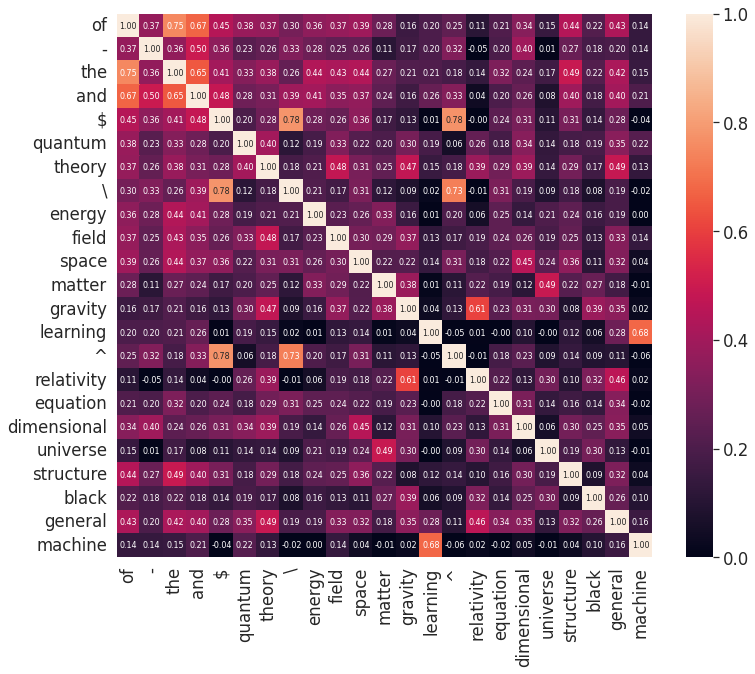

In [ ]:
heatmap = avm.embedding_cosine_heatmap(model=best_model,
                                       words=heatmap_words,
                                       word_to_idx=title_word_to_idx)

In [ ]:
pca = avm.pca_3d_embedding_plotter_topk(model=best_model,
                                     words=pca_words,
                                     word_to_idx=title_word_to_idx,
                                     idx_to_word=title_idx_to_word,
                                     title='PCA',
                                     k=5)

In [ ]:
tsne = avm.tsne_3d_embedding_plotter_topk(model=best_model,
                                     words=tsne_words,
                                     word_to_idx=title_word_to_idx,
                                     idx_to_word=title_idx_to_word,
                                     title='t-SNE',
                                     k=5)

In [ ]:
pca.show()

In [ ]:
tsne.show()

In [ ]:
avm.embedding_utils.topk_analogies_df(best_model,
                                      'newton mechanics heisenberg'.split(),
                                      title_word_to_idx,
                                      title_idx_to_word)